<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · Práctica</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Nombre y apellidos:</strong> Carlos Martínez Carreño
</div>

Primero cargamos las librerias necesarias:

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing.image import DirectoryIterator 
from keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D)
from keras.layers.experimental.preprocessing import Resizing
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import Sequential, Model
import cv2
import glob
import os
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

## Ejercicio 1
Elaborar un analisis exploratorio de los datos del problema:
* Porcentaje de imagenes de cada clase
* Numero total de imagenes para cada clase
* Muestra al menos 5 imagenes de cada clase

### Numero total de imagenes de cada clase:

In [2]:
for typ in os.listdir('../input/kaggle-plant-pathology-2021-modificat/train'):
    print(typ + ': ' + str(len(os.listdir('../input/kaggle-plant-pathology-2021-modificat/train' + '/' + typ))))

C5: 1150
C2: 1200
C4: 1300
C3: 1100
C1: 1000
C0: 4000


### Porcentaje de imagenes de cada clase:

In [3]:
total = 0
for typ in os.listdir('../input/kaggle-plant-pathology-2021-modificat/train'):
    total = total + len(os.listdir('../input/kaggle-plant-pathology-2021-modificat/train' + '/' + typ))
    
total

9750

In [4]:
typeOfLeaf = []
for typ in os.listdir('../input/kaggle-plant-pathology-2021-modificat/train'):
    value = len(os.listdir('../input/kaggle-plant-pathology-2021-modificat/train' + '/' + typ))
    typeOfLeaf.append(typ)
    print(typ + ': ' + str(value*100/total))

C5: 11.794871794871796
C2: 12.307692307692308
C4: 13.333333333333334
C3: 11.282051282051283
C1: 10.256410256410257
C0: 41.02564102564103


### Muestra al menos 5 imagenes de cada clase:

In [5]:
def plotClass(classType):
    count= 1
    columns = 3
    rows = 7
    number = 0
    fig = plt.figure(figsize=(20, 20))
    for jpg in os.listdir('../input/kaggle-plant-pathology-2021-modificat/train/'+ classType):
        number = number + 1
        img = plt.imread('../input/kaggle-plant-pathology-2021-modificat/train/' + classType + '/' + jpg)
        fig.add_subplot(rows,columns, count)
        fig.tight_layout(pad=1.0)
        count = count + 1
        plt.imshow(img)
        plt.title(typ)
        if(number > 4):
            break
        else:
            continue
    plt.show()

#### C0

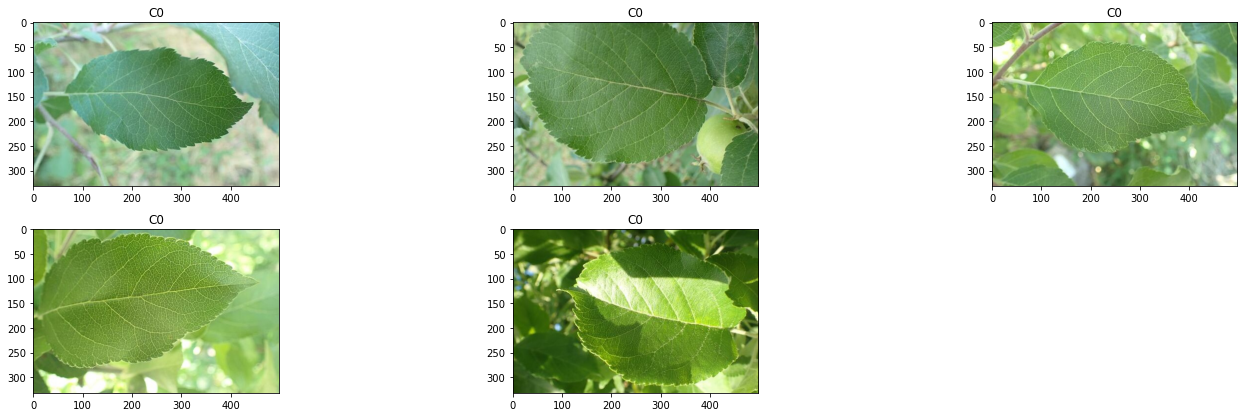

In [6]:
plotClass('C0')

#### C1

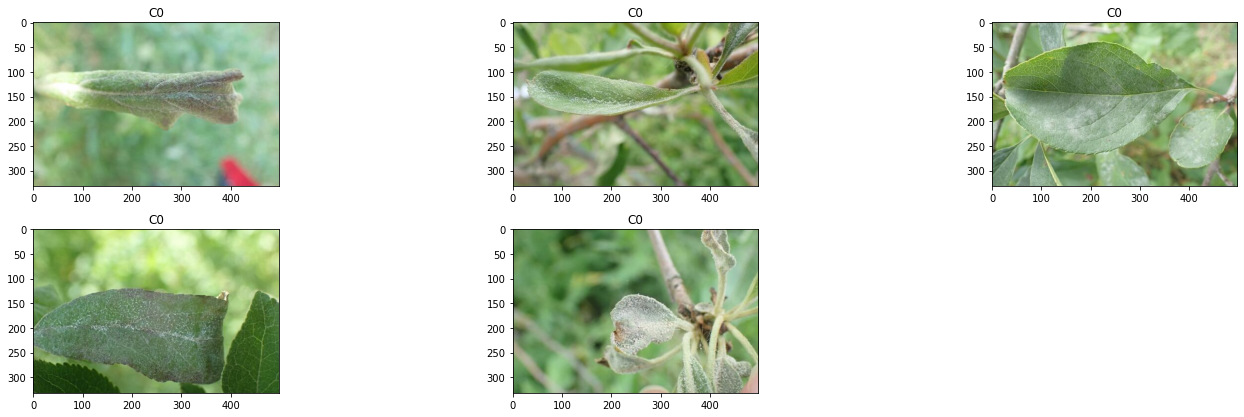

In [7]:
plotClass('C1')

#### C2

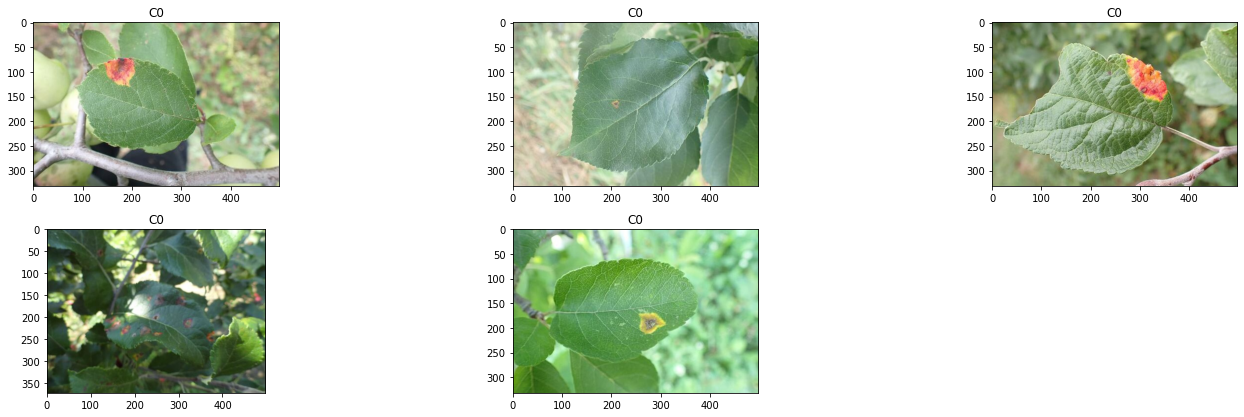

In [8]:
plotClass('C2')

#### C3

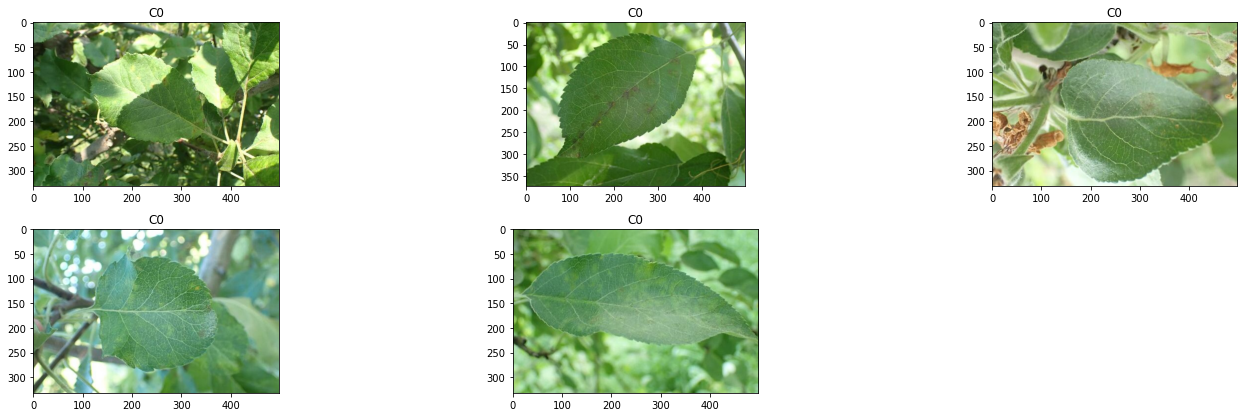

In [9]:
plotClass('C3')

#### C4

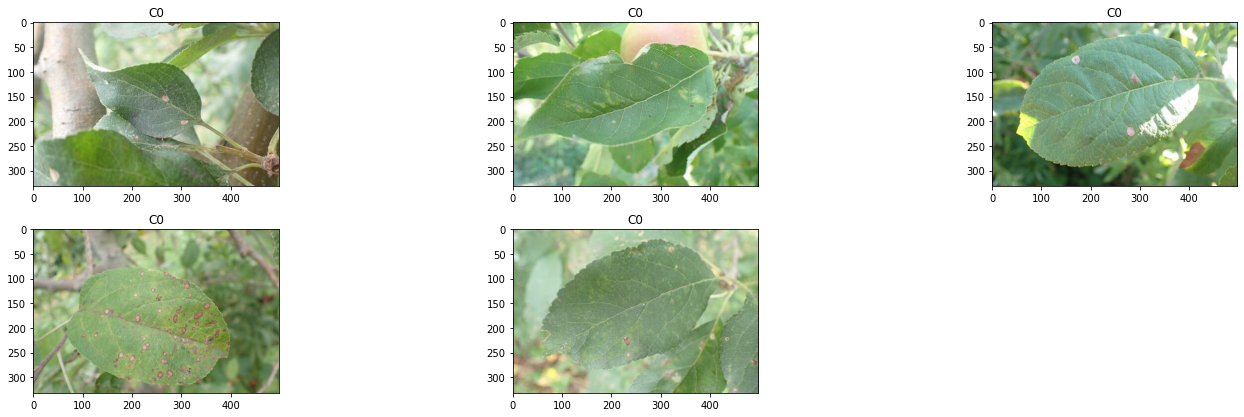

In [10]:
plotClass('C4')

#### C5

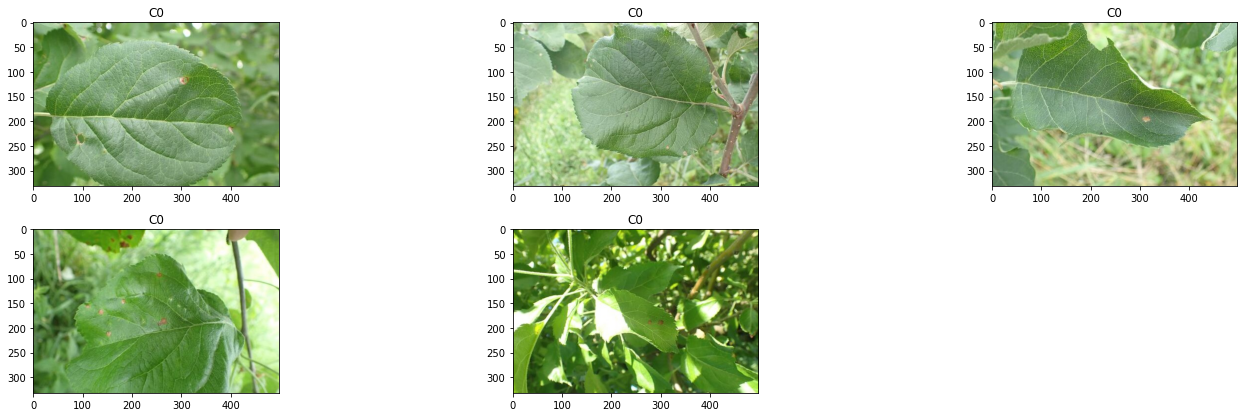

In [11]:
plotClass('C5')

## Ejercicio 2
Definición de la estrategía de validación.

Para definir la estrategia de validación vamos a crear los callbacks que vamos a usar para los modelos.  Los callbacks usados van a ser un checkpoint para guardar el mejor modelo y un Early Stopper de 4 épocas que monitoriza la función f1 score en validación

In [12]:
def get_callbacks(path):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = path,
        monitor = "val_f1_score",
        mode ='max',
        save_best_only=True,
        verbose=1,
    )
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_f1_score",
        mode ='max',
        patience = 4, 
        verbose =1
    )
    
    callbacks = [checkpoint, earlystop]         
    return callbacks

Para optimizador vamos a usar Adam, con un learning rate de 0.0001, como loss Categorical Cross Entropy y como metrica la solicitada, F1 socre

In [13]:
def compile_model(model):
    model.compile(optimizer=Adam(lr= 0.0001),loss='categorical_crossentropy',metrics= [tfa.metrics.F1Score(num_classes = 6, average = "macro",name = "f1_score")])
    return model

## Ejercicio 3
* Definición de la estrategía de aumento de datos sobre el conjunto de entrenamiento
* Elegir el tipo de modelo y tamaño de entrada que se utilizará para la predicción.
* Elegir el tipo de estrategia de entrenamiento que se seguirá.
* Mostrar las gráficas de entrenamiento donde se pueda ver claramente la evolución de la función de pérdida y de la función de evaluación FScore tanto para el conjunto de entrenamiento como para el de validación.
* Elegir el modelo con mejor rendimiento (aquel que tiene la máxima F1 Sobre el conjunto de validación)

### Definición de la estrategía de aumento de datos sobre el conjunto de entrenamiento

Vamos a tener dos grupos de datos. Entrenamiento y validacion, que contienen las labels definidas. Siendo el conjunto de validación 3/10 del total de ejemplos del train y un 2/3 para el conjunto de entrenamiento. 

In [14]:
dataGen = ImageDataGenerator(rescale = 1./255, validation_split=0.30)
train_generator = dataGen.flow_from_directory(
    '../input/kaggle-plant-pathology-2021-modificat/train',
    target_size = (332,498),
    color_mode="rgb",
    class_mode="categorical",
    classes = typeOfLeaf,
    batch_size=30, 
    shuffle=True,
    subset = 'training'
)
validation_generator = dataGen.flow_from_directory(
    '../input/kaggle-plant-pathology-2021-modificat/train',
    target_size = (332,498),
    color_mode="rgb",
    class_mode="categorical",
    classes = typeOfLeaf,
    batch_size=30, 
    shuffle=True,
    subset = 'validation'
)

Found 6825 images belonging to 6 classes.
Found 2925 images belonging to 6 classes.


Para obtener los datos de test, que no contienen etiquetas, usaremos la misma metodología pero haciendo un pequeño truco

In [15]:
dataGenTest = ImageDataGenerator(rescale = 1./255)
test_generator = dataGen.flow_from_directory(
    '../input/kaggle-plant-pathology-2021-modificat',
    target_size = (332,498),
    color_mode = "rgb",
    batch_size = 39, 
    shuffle = False,
    classes=['test'])

Found 7527 images belonging to 1 classes.


### Elegir el tipo de modelo, tamaño de entrada y la estrategia de entrenamiento que se utilizará para la predicción.

Para empezar vamos a generar un modelo baseline sencillo para ver que tal funciona. Despues he decidido usar un modelo ya preentrenado como es el modelo DenseNet121 que he visto que funciona correctamente en este tipo de casuisticas.

#### Modelo Baseline

Para el modelo baseline vamos a utilizar una una capa que realizara un resize a (32,32) mas luego dos capas completamente conectadas. La primera D1024, y la ultima tendra las 6 categorias que queremos clasificar. entre las capas conectadas usaremos un dropout del 0.5 y para el resizing usaremos un Flatten. Lo entrenaremos durante 20 epocas.

In [16]:
BLmodel = Sequential(name="baseline")
BLmodel.add(Resizing(32,32,interpolation="bilinear", name='Reduccion', input_shape = (332,498,3)))
BLmodel.add(Flatten())
BLmodel.add(Dense(1024, activation='relu'))
BLmodel.add(Dropout(0.2))
BLmodel.add(Dense(6, activation='softmax'))
BLmodel.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Reduccion (Resizing)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 3,152,902
Trainable params: 3,152,902
Non-trainable params: 0
_________________________________________________________________


In [17]:
tf.keras.backend.clear_session()
with tf.device('/device:GPU:0'):
    BLmodelC = compile_model(BLmodel)
    BLcallbacks = get_callbacks('model_baseline.h5')
    BLHistory = BLmodelC.fit(train_generator, 
                        epochs = 20, 
                        callbacks=BLcallbacks, 
                        validation_data = validation_generator,
                        verbose = 1)

Epoch 1/20
228/228 [==============================] - 104s 452ms/step - loss: 1.7035 - f1_score: 0.1626 - val_loss: 1.4947 - val_f1_score: 0.1613

Epoch 00001: val_f1_score improved from -inf to 0.16131, saving model to model_baseline.h5
Epoch 2/20
228/228 [==============================] - 72s 317ms/step - loss: 1.4971 - f1_score: 0.2152 - val_loss: 1.5027 - val_f1_score: 0.1631

Epoch 00002: val_f1_score improved from 0.16131 to 0.16313, saving model to model_baseline.h5
Epoch 3/20
228/228 [==============================] - 72s 316ms/step - loss: 1.4712 - f1_score: 0.2397 - val_loss: 1.4272 - val_f1_score: 0.2463

Epoch 00003: val_f1_score improved from 0.16313 to 0.24626, saving model to model_baseline.h5
Epoch 4/20
228/228 [==============================] - 72s 316ms/step - loss: 1.4025 - f1_score: 0.2540 - val_loss: 1.4341 - val_f1_score: 0.2635

Epoch 00004: val_f1_score improved from 0.24626 to 0.26350, saving model to model_baseline.h5
Epoch 5/20
228/228 [======================

In [18]:
resultadosBL = pd.DataFrame(BLHistory.history)

with open('baseline_history.csv', mode='w') as f:
    resultadosBL.to_csv(f)

El algoritmo ha consumido una gran cantidad de tiempo y obtiene una mala precision. Pero nos da una idea general de como tenemos que orientar el problema

#### Modelo DenseNet121 -> D72 -> D36 -> D6

Una vez modelado este baseline vemos que entrenar este tipo de algoritmos es costoso en tiempo y se obtiene una mala precision. Por ello vamos a usar un modelo preentrenado como el modelo DenseNet121 seguido de una capa completamente conectada de 3 capas (72, 36, 6) con dropout entre ellas para evitar el overfitting:

In [19]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
DNmodel = Sequential(name="denseNet")
DNmodel.add(tf.keras.applications.DenseNet121(input_shape=(332,498,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling='avg'))
DNmodel.add(Dense(72, activation='relu'))
DNmodel.add(Dropout(0.2))
DNmodel.add(Dense(36, activation='relu'))
DNmodel.add(Dropout(0.2))
DNmodel.add(Dense(6, activation='softmax'))
DNmodel.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "denseNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 72)                73800     
_________________________________________________________________
dropout (Dropout)            (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                2628      
_________________________________________________________________
dropout_1 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 222       
Total params: 7,114,154
Trainable params: 7,030,506
Non-tra

In [20]:
tf.keras.backend.clear_session()
with tf.device('/device:GPU:0'):
    DNmodelC = compile_model(DNmodel)
    DNcallbacks = get_callbacks('densenet_model.h5')
    DNHistory = DNmodelC.fit(train_generator, 
                        epochs = 10, 
                        callbacks=DNcallbacks, 
                        validation_data = validation_generator,
                        verbose = 1)

Epoch 1/10
228/228 [==============================] - 168s 673ms/step - loss: 1.0057 - f1_score: 0.5473 - val_loss: 0.5900 - val_f1_score: 0.7788

Epoch 00001: val_f1_score improved from -inf to 0.77875, saving model to densenet_model.h5
Epoch 2/10
228/228 [==============================] - 149s 655ms/step - loss: 0.3113 - f1_score: 0.8799 - val_loss: 0.3634 - val_f1_score: 0.8685

Epoch 00002: val_f1_score improved from 0.77875 to 0.86854, saving model to densenet_model.h5
Epoch 3/10
228/228 [==============================] - 150s 658ms/step - loss: 0.1849 - f1_score: 0.9337 - val_loss: 0.3067 - val_f1_score: 0.8872

Epoch 00003: val_f1_score improved from 0.86854 to 0.88720, saving model to densenet_model.h5
Epoch 4/10
228/228 [==============================] - 149s 654ms/step - loss: 0.1621 - f1_score: 0.9397 - val_loss: 0.3283 - val_f1_score: 0.8758

Epoch 00004: val_f1_score did not improve from 0.88720
Epoch 5/10
228/228 [==============================] - 149s 654ms/step - loss: 

In [21]:
resultadosDN = pd.DataFrame(DNHistory.history)

with open('denseNet_history.csv', mode='w') as f:
    resultadosDN.to_csv(f)

Evaluamos el modelo con los datos de validacion al completo para checkear que el f1 score es correcto:

In [22]:
loss, f1Score = DNmodel.evaluate(validation_generator,verbose=1)
print('La pérdida  es {} y f1-score es {}'.format(round(loss,4), round(f1Score,4)))

98/98 [==============================] - 26s 252ms/step - loss: 0.3098 - f1_score: 0.8989
La pérdida  es 0.3098 y f1-score es 0.8989


Podemos ver como concuerda.

### Mostrar las gráficas de entrenamiento donde se pueda ver claramente la evolución de la función de pérdida y de la función de evaluación FScore tanto para el conjunto de entrenamiento como para el de validación.

Vamos a realizar graficas tanto para el modelo Baseline como para el modelo DenseNet para compararlos.

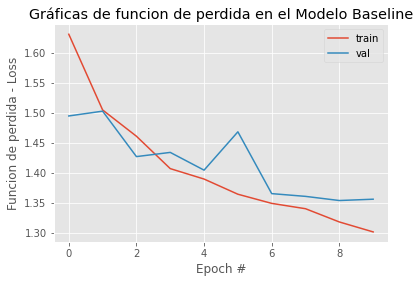

In [23]:
plt.style.use("ggplot")
plt.plot(np.arange(0,len(BLHistory.history["loss"])), BLHistory.history["loss"], label="train")
plt.plot(np.arange(0,len(BLHistory.history["val_loss"])), BLHistory.history["val_loss"], label="val")
plt.title("Gráficas de funcion de perdida en el Modelo Baseline")
plt.xlabel("Epoch #")
plt.ylabel("Funcion de perdida - Loss")
plt.legend(loc="upper right")
plt.show()

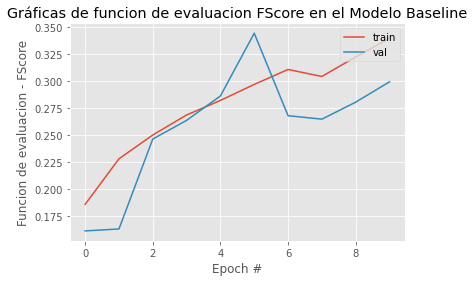

In [24]:
plt.style.use("ggplot")
plt.plot(np.arange(0,len(BLHistory.history["f1_score"])), BLHistory.history["f1_score"], label="train")
plt.plot(np.arange(0,len(BLHistory.history["val_f1_score"])), BLHistory.history["val_f1_score"], label="val")
plt.title("Gráficas de funcion de evaluacion FScore en el Modelo Baseline")
plt.xlabel("Epoch #")
plt.ylabel("Funcion de evaluacion - FScore")
plt.legend(loc="upper right")
plt.show()

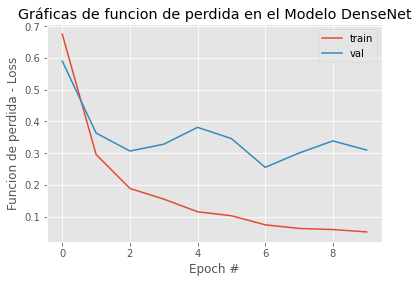

In [25]:
plt.style.use("ggplot")
plt.plot(np.arange(0,len(DNHistory.history["loss"])), DNHistory.history["loss"], label="train")
plt.plot(np.arange(0,len(DNHistory.history["val_loss"])), DNHistory.history["val_loss"], label="val")
plt.title("Gráficas de funcion de perdida en el Modelo DenseNet")
plt.xlabel("Epoch #")
plt.ylabel("Funcion de perdida - Loss")
plt.legend(loc="upper right")
plt.show()

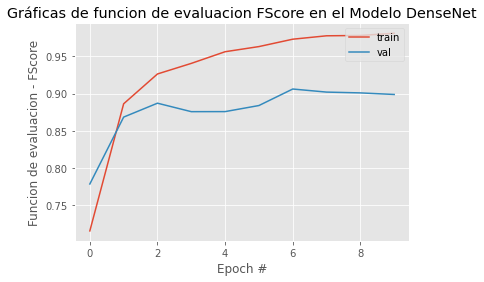

In [26]:
plt.style.use("ggplot")
plt.plot(np.arange(0,len(DNHistory.history["f1_score"])), DNHistory.history["f1_score"], label="train")
plt.plot(np.arange(0,len(DNHistory.history["val_f1_score"])), DNHistory.history["val_f1_score"], label="val")
plt.title("Gráficas de funcion de evaluacion FScore en el Modelo DenseNet")
plt.xlabel("Epoch #")
plt.ylabel("Funcion de evaluacion - FScore")
plt.legend(loc="upper right")
plt.show()

###  Elegir el modelo con mejor rendimiento (aquel que tiene la máxima F1 Sobre el conjunto de validación)

Como hemos podido ver mediante las graficas, el mejor modelo es el preentrenado **DenseNet**. Vamos a seleccionar ese.

## Ejercicio 4
* Presentar para el modelo que haya dado mejores resultados de la funcion de evaluacion las siguientes medidas de rendimiento adicionales: matriz de confusion, F1-Score, Accuracy, Precision y Recall (todas ellas con media ponderada)
* Calcular las predicciones del conjunto de test proporcionado y guarda en un CSV con dos campos: nombre del archivo de la imagen analizada y la clase predicha.

###   Presentar para el modelo que haya dado mejores resultados de la funcion de evaluacion las siguientes medidas de rendimiento adicionales: matriz de confusion, F1-Score, Accuracy, Precision y Recall

In [27]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
DNmodelF = Sequential(name="denseNetFinal")
DNmodelF.add(tf.keras.applications.DenseNet121(input_shape=(332,498,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling='avg'))
DNmodelF.add(Dense(72, activation='relu'))
DNmodelF.add(Dropout(0.2))
DNmodelF.add(Dense(36, activation='relu'))
DNmodelF.add(Dropout(0.2))
DNmodelF.add(Dense(6, activation='softmax'))
DNmodelF.summary()

Model: "denseNetFinal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 72)                73800     
_________________________________________________________________
dropout (Dropout)            (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                2628      
_________________________________________________________________
dropout_1 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 222       
Total params: 7,114,154
Trainable params: 7,030,506
Non-trainable params: 83,648
______________________________________

In [28]:
with tf.device('/device:GPU:0'):
    DNmodelF.compile(optimizer=Adam(lr= 0.0001),loss='categorical_crossentropy',metrics= [tfa.metrics.F1Score(num_classes = 6, average = "macro",name = "f1_score"),
                                                                                      keras.metrics.CategoricalAccuracy(name='accuracy'),
                                                                                      keras.metrics.Precision(name='precision'),
                                                                                      keras.metrics.Recall(name='recall')])
    DNFcallbacks = get_callbacks('densenet_model_final.h5')
    DNHistoryF = DNmodelF.fit(train_generator, 
                        epochs = 10, 
                        callbacks=DNFcallbacks, 
                        validation_data = validation_generator,
                        verbose = 1)

Epoch 1/10
228/228 [==============================] - 163s 671ms/step - loss: 1.0869 - f1_score: 0.5477 - accuracy: 0.6106 - precision: 0.8167 - recall: 0.4079 - val_loss: 0.6275 - val_f1_score: 0.7579 - val_accuracy: 0.8154 - val_precision: 0.8343 - val_recall: 0.7956

Epoch 00001: val_f1_score improved from -inf to 0.75790, saving model to densenet_model_final.h5
Epoch 2/10
228/228 [==============================] - 150s 657ms/step - loss: 0.2744 - f1_score: 0.9008 - accuracy: 0.9232 - precision: 0.9433 - recall: 0.8893 - val_loss: 0.3194 - val_f1_score: 0.8858 - val_accuracy: 0.9063 - val_precision: 0.9186 - val_recall: 0.8950

Epoch 00002: val_f1_score improved from 0.75790 to 0.88585, saving model to densenet_model_final.h5
Epoch 3/10
228/228 [==============================] - 151s 659ms/step - loss: 0.2117 - f1_score: 0.9253 - accuracy: 0.9401 - precision: 0.9562 - recall: 0.9187 - val_loss: 0.3743 - val_f1_score: 0.8706 - val_accuracy: 0.8957 - val_precision: 0.9135 - val_recall

### Calcular las predicciones del conjunto de test proporcionado y guarda en un CSV con dos campos: nombre del archivo de la imagen analizada y la clase predicha.

In [29]:
predicciones = DNmodelF.predict(test_generator)

In [30]:
indices_pred = predicciones.argmax(axis=-1)
ficheros_test = [str(i).replace('test/', '')  for i in test_generator.filenames]
preds_clases = np.vectorize({v: k for k, v in train_generator.class_indices.items()}.get)(indices_pred)
filenamesLabeled = list(zip(ficheros_test, preds_clases))

In [31]:
from collections import Counter
print("conteo de predicciones: {}".format(Counter(preds_clases)))

conteo de predicciones: Counter({'C3': 3134, 'C5': 1865, 'C0': 1162, 'C2': 725, 'C4': 341, 'C1': 300})


In [32]:
predFile = pd.DataFrame(filenamesLabeled, columns=['image','label'])
with open('test.csv', mode='w') as f:
    predFile.to_csv(f)

In [33]:
pred_val = DNmodelF.predict(validation_generator)
pred_val = np.argmax(pred_val, axis=-1)

Vamos a presentar graficametne todas las metricas obtenidas:

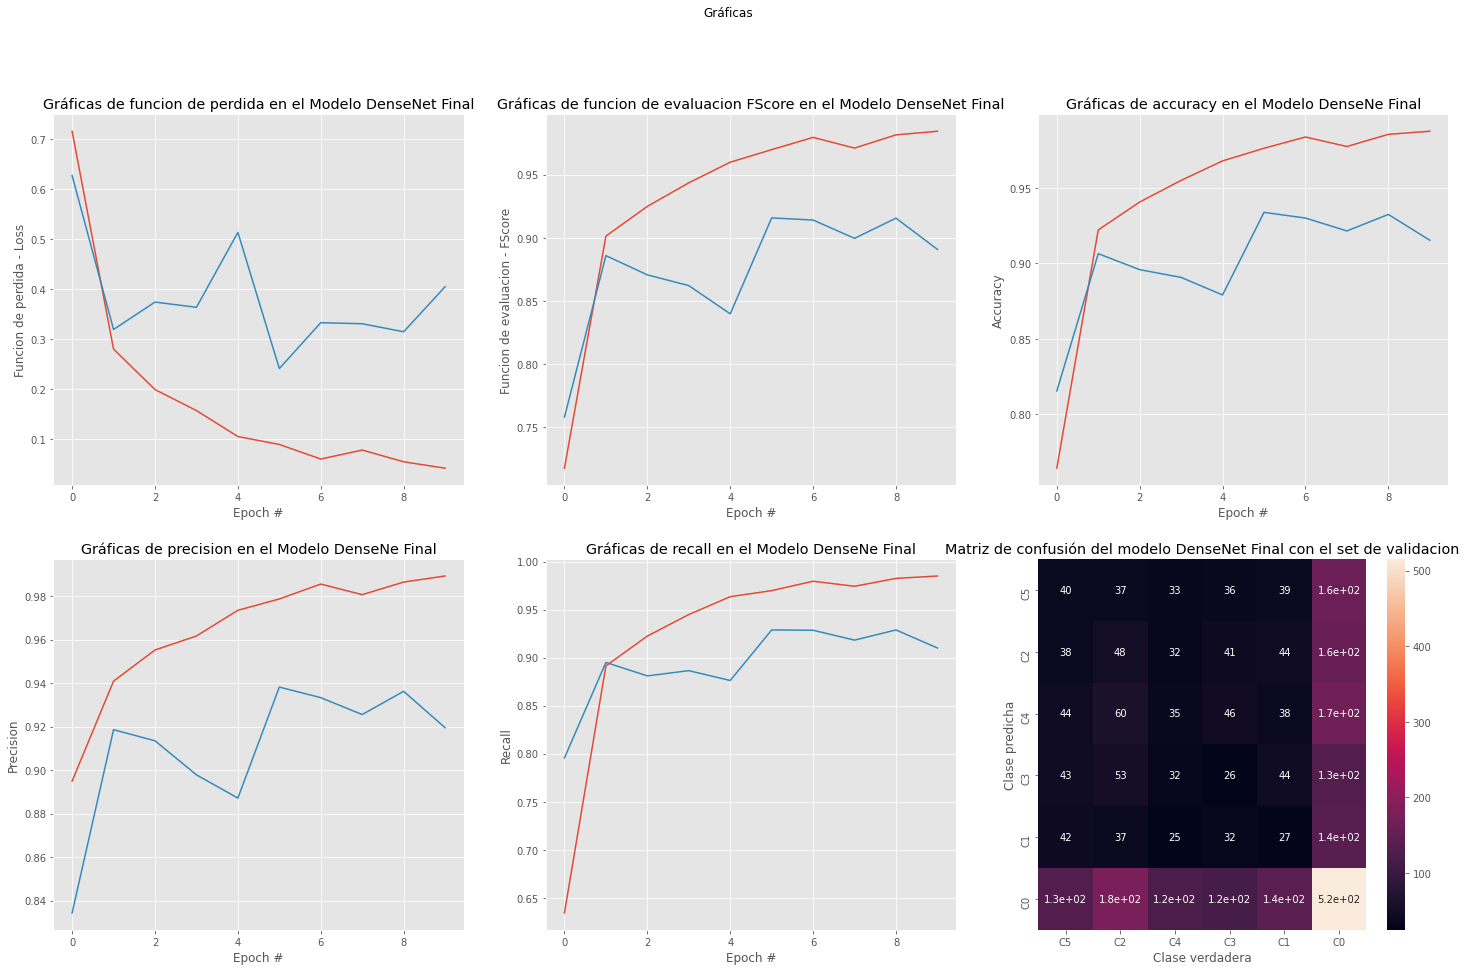

In [34]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(25,15))
plt.suptitle("Gráficas")
plt.style.use("ggplot")

ax1.plot(np.arange(0,len(DNHistoryF.history["loss"])), DNHistoryF.history["loss"], label="train")
ax1.plot(np.arange(0,len(DNHistoryF.history["val_loss"])), DNHistoryF.history["val_loss"], label="val")
ax1.set_title("Gráficas de funcion de perdida en el Modelo DenseNet Final")
ax1.set_xlabel("Epoch #")
ax1.set_ylabel("Funcion de perdida - Loss")

ax2.plot(np.arange(0,len(DNHistoryF.history["f1_score"])), DNHistoryF.history["f1_score"], label="train")
ax2.plot(np.arange(0,len(DNHistoryF.history["val_f1_score"])), DNHistoryF.history["val_f1_score"], label="val")
ax2.set_title("Gráficas de funcion de evaluacion FScore en el Modelo DenseNet Final")
ax2.set_xlabel("Epoch #")
ax2.set_ylabel("Funcion de evaluacion - FScore")

ax3.plot(np.arange(0,len(DNHistoryF.history["accuracy"])), DNHistoryF.history["accuracy"], label="train")
ax3.plot(np.arange(0,len(DNHistoryF.history["val_accuracy"])), DNHistoryF.history["val_accuracy"], label="val")
ax3.set_title("Gráficas de accuracy en el Modelo DenseNe Final")
ax3.set_xlabel("Epoch #")
ax3.set_ylabel("Accuracy")

ax4.plot(np.arange(0,len(DNHistoryF.history["precision"])), DNHistoryF.history["precision"], label="train")
ax4.plot(np.arange(0,len(DNHistoryF.history["val_precision"])), DNHistoryF.history["val_precision"], label="val")
ax4.set_title("Gráficas de precision en el Modelo DenseNe Final")
ax4.set_xlabel("Epoch #")
ax4.set_ylabel("Precision")

ax5.plot(np.arange(0,len(DNHistoryF.history["recall"])), DNHistoryF.history["recall"], label="train")
ax5.plot(np.arange(0,len(DNHistoryF.history["val_recall"])), DNHistoryF.history["val_recall"], label="val")
ax5.set_title("Gráficas de recall en el Modelo DenseNe Final")
ax5.set_xlabel("Epoch #")
ax5.set_ylabel("Recall")

import seaborn as sns
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(validation_generator.classes, pred_val)
orden = validation_generator.class_indices.keys()
sns.heatmap(cm, annot=True, xticklabels=orden, yticklabels=orden)
ax6.set_title("Matriz de confusión del modelo DenseNet Final con el set de validacion")
ax6.set_xlabel('Clase verdadera')
ax6.set_ylabel('Clase predicha')

plt.show()

No comprendo muy bien porque los datos de la matriz de confusion no son del todo exactos

Al final he comprendido que la matriz debe hacerse sobre los datos de validacion ordenados:

Found 2925 images belonging to 6 classes.


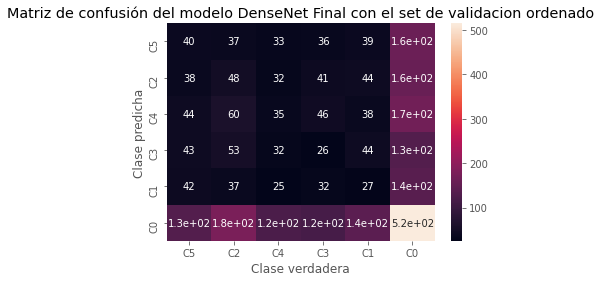

In [35]:
validation_generator_ordenados = dataGen.flow_from_directory(
    '../input/kaggle-plant-pathology-2021-modificat/train',
    target_size = (332,498),
    color_mode="rgb",
    class_mode="categorical",
    classes = typeOfLeaf,
    batch_size=30, 
    shuffle=False,
    subset = 'validation'
)
pred_val_ord = DNmodelF.predict(validation_generator_ordenados)
pred_val_ord = np.argmax(pred_val_ord, axis=-1)
cm  = confusion_matrix(validation_generator_ordenados.classes, pred_val)
orden = validation_generator_ordenados.class_indices.keys()
sns.heatmap(cm, annot=True, xticklabels=orden, yticklabels=orden)
plt.title("Matriz de confusión del modelo DenseNet Final con el set de validacion ordenado")
plt.xlabel('Clase verdadera')
plt.ylabel('Clase predicha')
plt.show()